<a href="https://www.kaggle.com/code/anlzcan/heart-attack-prediction-knn-dt-nn?scriptVersionId=156991414" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform, poisson
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
# data load
df = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
df_satur = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv")

# Data Preparation

In [5]:
df_satur["98.6"].unique() # does not look like meaningfull data 

array([98.6, 98.1, 97.5, 98. , 97. , 96.5, 97.1, 97.6, 98.2, 96.9, 97.9,
       97.2, 99.3, 98.9, 98.3, 99.6, 98.8])

In [6]:
def calculate_cardinality(dataframe):
    column_cardinality = {}
    for column in dataframe.columns:
        cardinality = dataframe[column].nunique()
        column_cardinality[column] = cardinality
    return column_cardinality

In [7]:
df_cardinality = calculate_cardinality(df)

In [8]:
#looks like no unique variable. We wont drop any column as id or high cardinality
df_cardinality

{'age': 41,
 'sex': 2,
 'cp': 4,
 'trtbps': 49,
 'chol': 152,
 'fbs': 2,
 'restecg': 3,
 'thalachh': 91,
 'exng': 2,
 'oldpeak': 40,
 'slp': 3,
 'caa': 5,
 'thall': 4,
 'output': 2}

In [9]:
missing_values = df.isnull().sum() # checking null values

In [10]:
missing_values #looks like no missing values - nothing will dropped

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [11]:
df.duplicated().sum()

1

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42) # first split as train-test

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 132 to 102
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       241 non-null    int64  
 1   sex       241 non-null    int64  
 2   cp        241 non-null    int64  
 3   trtbps    241 non-null    int64  
 4   chol      241 non-null    int64  
 5   fbs       241 non-null    int64  
 6   restecg   241 non-null    int64  
 7   thalachh  241 non-null    int64  
 8   exng      241 non-null    int64  
 9   oldpeak   241 non-null    float64
 10  slp       241 non-null    int64  
 11  caa       241 non-null    int64  
 12  thall     241 non-null    int64  
 13  output    241 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 28.2 KB


# Usefull functions

In [15]:
def get_df_name(df): # function to get dataframe name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [16]:
def separate_X_y(dataframe_names, independent_vars):
    """
    a function to seperate test, train sets' X and y variables
    
    Input:
        dataframe_names: the dataframe that used for extraction X and y variables
        inpendendent_vars: independent variables used during extraction
    Return:
        X_train: Independent variables of train data.
        y_train: Dependent variables of train data.
        X_test: Independent variables of test data.
        y_test: Dependent variables of test data.
    
    """
    datasets = {}
    
    for i in tuple(dataframe_names):
        X = "X_" + get_df_name(i).replace("_data", "")
        y = "y_" + get_df_name(i).replace("_data", "")
        
        datasets[X] = i.loc[:, independent_vars]
        datasets[y] = i["output"]
    
    return datasets.get('X_train'), datasets.get('y_train'), datasets.get('X_test'), datasets.get("y_test")

# Exploratory Data Analysis

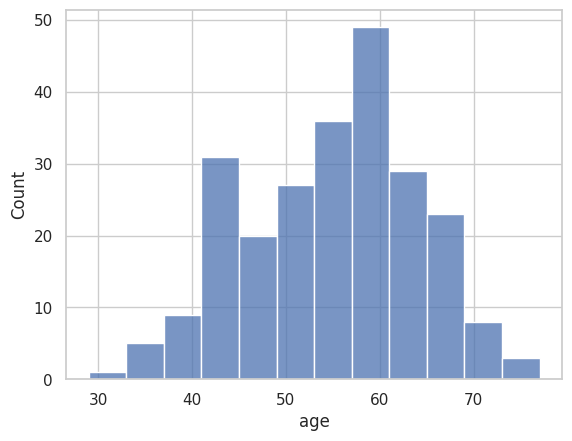

In [17]:
sns.histplot(train_data["age"]); 

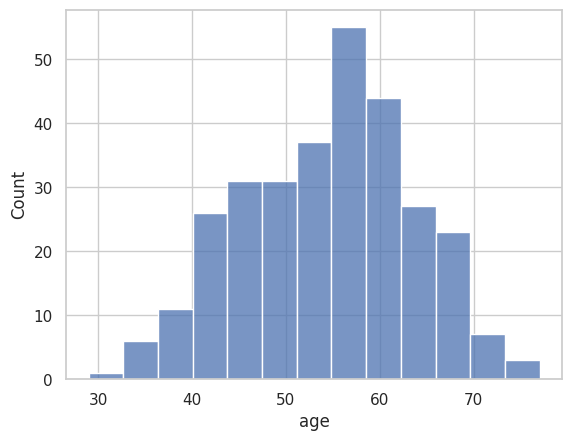

In [18]:
sns.histplot(df["age"]);

In [19]:
analysis_cols = [col for col in df.columns if col != "output"] # list compherension for columns to analyse

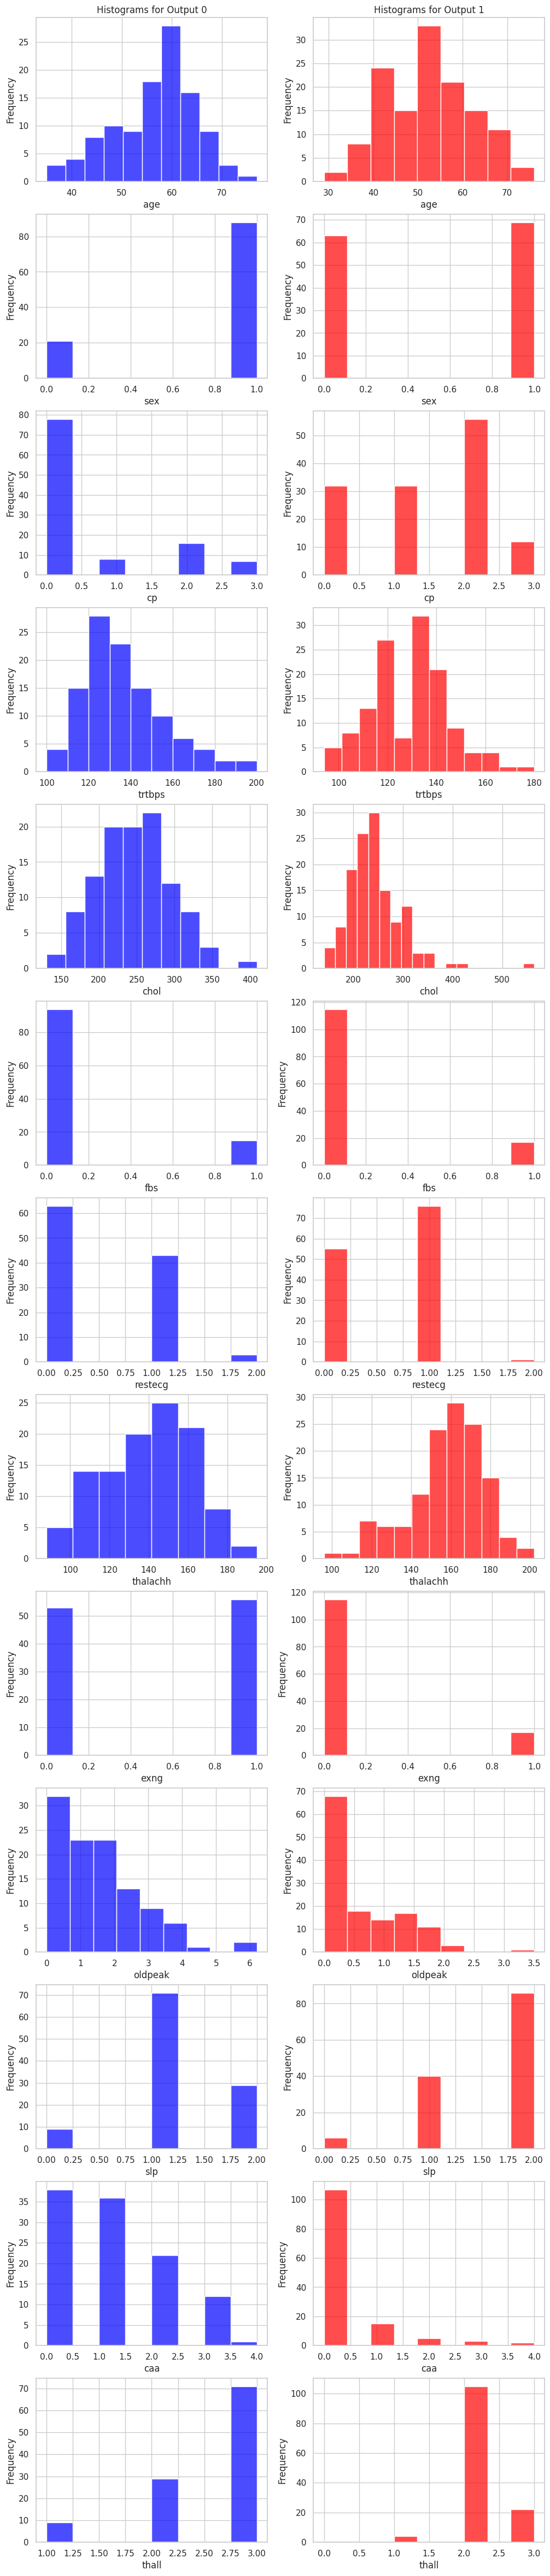

In [20]:
#creating for a plot to put subplots in.
fig, axes = plt.subplots(nrows= len(analysis_cols), ncols=2, figsize=(12, 60))
for index, col in enumerate(analysis_cols):
    sns.histplot(train_data[train_data["output"] == 0][col], color = "blue", alpha=0.7, ax = axes[index, 0])
    sns.histplot(train_data[train_data["output"] == 1][col], color = "red", alpha=0.7, ax = axes[index, 1])
    axes[index,0].set_xlabel(str(col))
    axes[index,0].set_ylabel('Frequency')
    if index == 0:
        axes[index,0].set_title('Histograms for Output 0')
        axes[index,1].set_title('Histograms for Output 1')
    axes[index,1].set_xlabel(str(col))
    axes[index,1].set_ylabel('Frequency')

In [21]:
#sns.histplot(df[df['output'] == 1]['age'], bins=2, color='blue', alpha=0.7, ax=axes[0])
#sns.histplot(df[df['output'] == 1]['output'], bins=2, color='blue', alpha=0.7, ax=axes[1])

# Modelling

In [22]:
train_data.info()
test_data.info() # 0.8 - 0.2 seperation looks like successfull.

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 132 to 102
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       241 non-null    int64  
 1   sex       241 non-null    int64  
 2   cp        241 non-null    int64  
 3   trtbps    241 non-null    int64  
 4   chol      241 non-null    int64  
 5   fbs       241 non-null    int64  
 6   restecg   241 non-null    int64  
 7   thalachh  241 non-null    int64  
 8   exng      241 non-null    int64  
 9   oldpeak   241 non-null    float64
 10  slp       241 non-null    int64  
 11  caa       241 non-null    int64  
 12  thall     241 non-null    int64  
 13  output    241 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 28.2 KB
<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 180 to 185
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       61 non-null     int64  
 1  

## KNN

In [23]:
independent_vars = [col for col in train_data if col != "output"]

### Base Model knn

In [24]:
scaler = MinMaxScaler()
numerical_columns = train_data.select_dtypes(include=['number']).columns

# Scale all numerical columns and replace the values in the DataFrame
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.fit_transform(test_data[numerical_columns])

In [25]:
X_train, y_train, X_test, y_test = separate_X_y([train_data, test_data], independent_vars = independent_vars)

In [26]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [27]:
%%time
knn.fit(X_train, y_train)

CPU times: user 4.13 ms, sys: 882 µs, total: 5.02 ms
Wall time: 4.83 ms


KNeighborsClassifier()

In [28]:
%%time
preds = knn.predict(X_test)

CPU times: user 11.2 ms, sys: 909 µs, total: 12.1 ms
Wall time: 12.3 ms


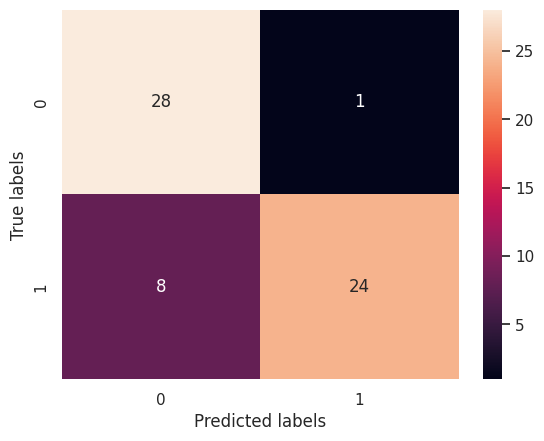

In [29]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [30]:
print("Classification Report:")
print(classification_report(y_test, preds)) # 0.82 accuracy

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86        29
         1.0       0.96      0.75      0.84        32

    accuracy                           0.85        61
   macro avg       0.87      0.86      0.85        61
weighted avg       0.87      0.85      0.85        61



### Grid Search Knn

In [31]:
param_grid = {"n_neighbors" : [5, 6, 7, 8, 9], "p": [1, 2, 3]} # number of neighbors and distance metric for hyperparameters.

In [32]:
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring = "accuracy") #grid search to find best params

In [33]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 6, 7, 8, 9], 'p': [1, 2, 3]},
             scoring='accuracy')

In [34]:
best_params = grid_search.best_params_

In [35]:
best_params 

{'n_neighbors': 7, 'p': 1}

In [36]:
best_score = grid_search.best_score_ # mean accuracy of best model

grid_search.cv_results_ # looking up cv accuracy results.

In [37]:
bestModel = KNeighborsClassifier(**best_params)

In [38]:
bestModel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, p=1)

In [39]:
preds = bestModel.predict(X_test)

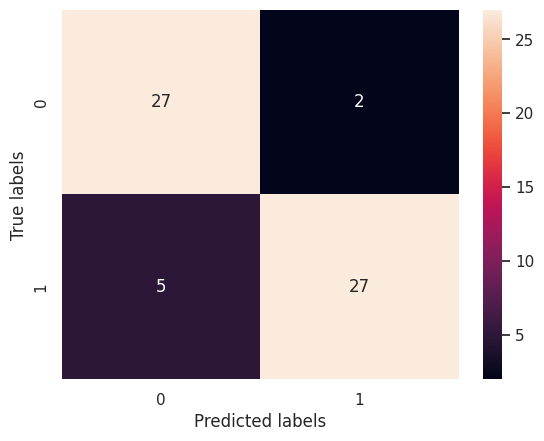

In [40]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [41]:
print("Classification Report:")
print(classification_report(y_test, preds)) #.84 accuracy metric.

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.89        29
         1.0       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



##  Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Base Model Decision Tree

In [43]:
dt = DecisionTreeClassifier()

In [44]:
%%time
dt.fit(X_train, y_train)

CPU times: user 5.1 ms, sys: 2.03 ms, total: 7.13 ms
Wall time: 8.3 ms


DecisionTreeClassifier()

In [45]:
preds = dt.predict(X_test)

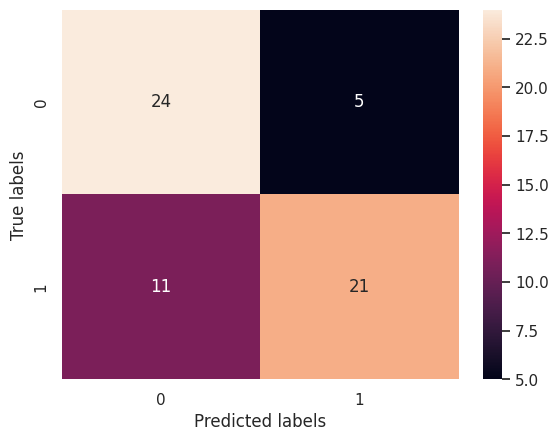

In [46]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [47]:
print("Classification Report:")
print(classification_report(y_test, preds)) #.70 accuracy

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75        29
         1.0       0.81      0.66      0.72        32

    accuracy                           0.74        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.74      0.74        61



### Pruning for Decision Tree (Pre pruning - Post Pruning)

In [48]:
# setup parameter space
parameters = {'max_depth':poisson(mu=2,loc=2),
              'max_leaf_nodes':poisson(mu=5,loc=5),
              'min_samples_split':uniform(),
              'min_samples_leaf':uniform()}

In [49]:
# create an instance of the randomized search object
rsearch = RandomizedSearchCV(DecisionTreeClassifier(random_state=28), 
                             parameters, cv=5, n_iter=100, random_state=28)

In [50]:
# conduct randomised search over the parameter space
rsearch.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=28),
                   n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b17b03250c0>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b17b0324c70>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b17b0357070>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b17b0354fa0>},
                   random_state=28)

In [51]:
dt_params = rsearch.best_params_
dt_params['min_samples_split'] = np.ceil(dt_params['min_samples_split']*X_train.shape[0])
dt_params['min_samples_leaf'] = np.ceil(dt_params['min_samples_leaf']*X_train.shape[0])
dt_params # getting best parameters for decision tree

{'max_depth': 4,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 12.0,
 'min_samples_split': 13.0}

In [52]:
dt_params

{'max_depth': 4,
 'max_leaf_nodes': 9,
 'min_samples_leaf': 12.0,
 'min_samples_split': 13.0}

In [53]:
bestModel = rsearch.best_estimator_

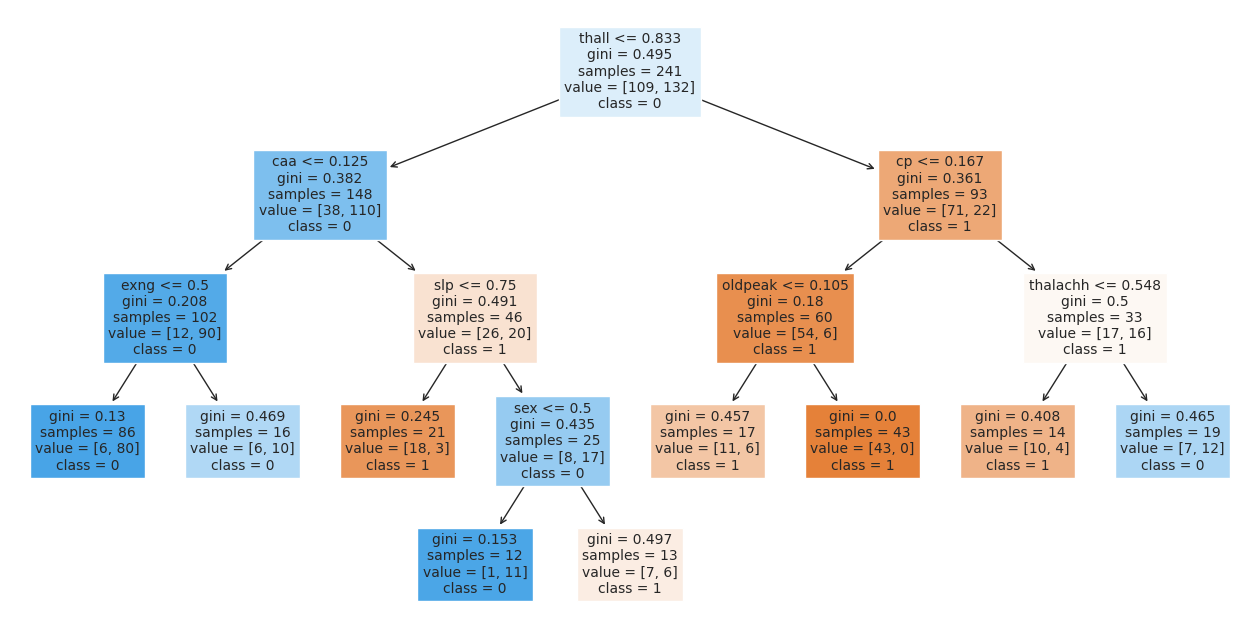

In [54]:
fig = plt.figure(figsize=(16,8))
_ = plot_tree(bestModel, 
              feature_names=independent_vars,
              filled=True,
              class_names= ["1","0"],
              fontsize=10)

In [55]:
train_data["output"].unique().tolist()

[1.0, 0.0]

In [56]:
preds = bestModel.predict(X_test)

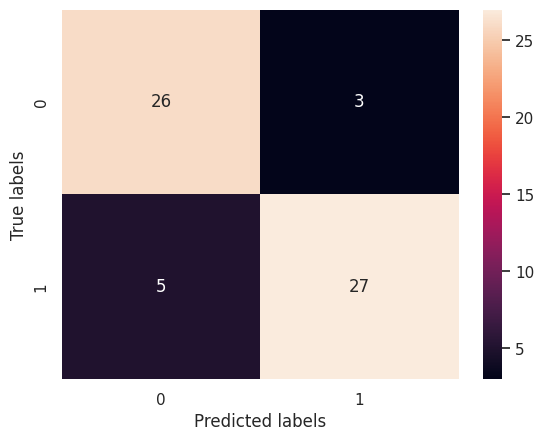

In [57]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [58]:
print("Classification Report:")
print(classification_report(y_test, preds)) #.74 accuracy 0.04 increase in accuracy. 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87        29
         1.0       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### Post Pruning

In [59]:
path = dt.cost_complexity_pruning_path(X_train, y_train) #using base model to post prune
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [60]:
ccp_alphas

array([0.        , 0.00272729, 0.00355661, 0.00373444, 0.0038036 ,
       0.00474215, 0.00574877, 0.00622407, 0.00653841, 0.00684647,
       0.00691563, 0.00691563, 0.00711322, 0.00721201, 0.00804728,
       0.0093242 , 0.00948429, 0.00983556, 0.01021385, 0.01072667,
       0.01152605, 0.01230168, 0.01259458, 0.01430627, 0.01570867,
       0.02616825, 0.02732713, 0.05270257, 0.12167886])

In [61]:
ccp_alphas = ccp_alphas[:-1] # alpha value of root

In [62]:
best_score = -1
best_pruned_tree = None

for ccp_alpha in ccp_alphas: # iterate over alphas and prune trees
    pruned_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    scores = cross_val_score(pruned_tree, X_train, y_train, cv=5)  # Perform cross-validation
    avg_score = scores.mean()
    
    if avg_score > best_score:
        best_score = avg_score
        best_pruned_tree = pruned_tree

In [63]:
best_pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.009484291641967988)

In [64]:
preds = best_pruned_tree.predict(X_test)

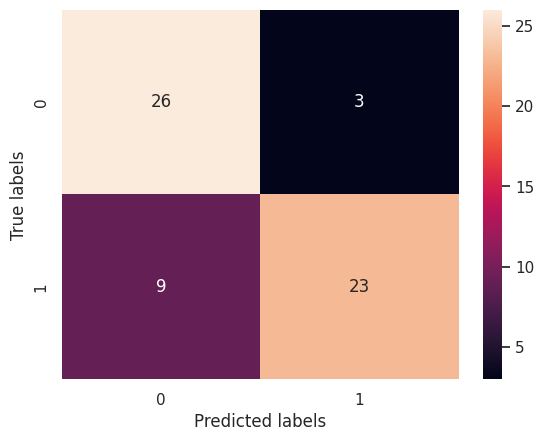

In [65]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [66]:
print("Classification Report:")
print(classification_report(y_test, preds)) #.70 accuracy. no significant increase in accuracy

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.90      0.81        29
         1.0       0.88      0.72      0.79        32

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.82      0.80      0.80        61



## Neural Network (Keras)

In [67]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42) # split as train-test

In [68]:
X_train_full, y_train_full, X_test, y_test = separate_X_y([train_data, test_data], independent_vars = independent_vars)

In [69]:
num_folds = 5 # number of folds

In [70]:
kf = KFold(n_splits=num_folds, shuffle=True) # creting of Kfold object

In [71]:
train_data.reset_index(drop = True, inplace = True)
X_train_full.reset_index(drop = True, inplace = True)
y_train_full.reset_index(drop = True, inplace = True)

In [72]:
%%time
accuracy_scores = []
for train_index, val_index in kf.split(train_data):
    # Splitting train data as train and validation
    X_train, X_val = X_train_full.iloc[train_index, :], X_train_full.iloc[val_index, :]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    
    # Model defining
    model = Sequential([
    Dense(units= 8, input_shape=(X_train.shape[1],), activation='relu'), # units can be tune actually.
    Dense(units= 1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs= 2000, batch_size=16, verbose=0, validation_data=(X_val, y_val))
    
    # predicting test inputs
    y_pred = model.predict(X_test)
    mask = y_pred > 0.5
    y_pred[mask] = 1
    y_pred[~mask] = 0
    
    # calculating accuracy and store in a list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Display avarage accuracy
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f'Average Accuracy across {num_folds}-fold cross-validation: {average_accuracy}')

2/2 [==============================] - 0s 4ms/step
Average Accuracy across 5-fold cross-validation: 0.8426229508196721
CPU times: user 10min 49s, sys: 48.8 s, total: 11min 37s
Wall time: 10min 49s


In [73]:
def create_model(neurons):
    model = Sequential([
    Dense(units= neurons, input_shape=(X_train_full.shape[1],),activation='relu'), # units can be tune actually.
    Dense(units= 1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [74]:
params_grid = {"batch_size" : [16, 32, 64],
               "epochs" : [50, 100, 150, 250, 500, 1000, 2000],
               "model__neurons": [16, 32, 64]
              }

In [75]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [76]:
%%time
grid = GridSearchCV(estimator=model, param_grid=params_grid, verbose=0, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train_full, y_train_full)

/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/conda/lib/python3.10/site-packages/scikeras

CPU times: user 52.4 s, sys: 6.4 s, total: 58.8 s
Wall time: 24min 59s


In [77]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.838350 using {'batch_size': 32, 'epochs': 2000, 'model__neurons': 16}


In [78]:
# predicting test inputs
y_pred = grid_result.predict(X_test)
mask = y_pred > 0.5
y_pred[mask] = 1
y_pred[~mask] = 0
    
# calculating accuracy and store in a list
accuracy = accuracy_score(y_test, y_pred)
accuracy_scores.append(accuracy)

In [79]:
accuracy_scores

[0.8360655737704918,
 0.8852459016393442,
 0.8524590163934426,
 0.8524590163934426,
 0.7868852459016393,
 0.8360655737704918]

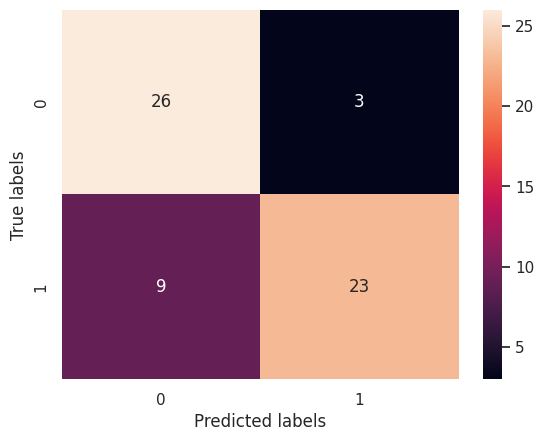

In [80]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

## Neural Network(Numpy)

In [81]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42) # split as train-test
independent_vars = [col for col in train_data if col != "output"]

In [82]:
scaler = MinMaxScaler()
numerical_columns = train_data.select_dtypes(include=['number']).columns

# Scale all numerical columns and replace the values in the DataFrame
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.fit_transform(test_data[numerical_columns])

In [83]:
X_train_full, y_train_full, X_test, y_test = separate_X_y([train_data, test_data], independent_vars = independent_vars)

In [84]:
# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid function will be used in backprop.
def sigmoid_derivative(x):
    return x * (1 - x)

# relu activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU function
def relu_derivative(x):
    return 1.0 * (x > 0)


## SGD

In [85]:
## SİLİNMEYECEK.
#optimization with stochastic gradient decent.
#splits X and y's
split = int(0.8 * len(X_train_full))
train_input = X_train_full.values[:split]
train_output = y_train_full.values[:split]
val_input = X_train_full.values[split:]
val_output = y_train_full.values[split:]

# Initialize weights and biases
input_size = train_input.shape[1]
hidden_size = 8
output_size = 1

np.random.seed(11)  # for reproducibility
hidden_weights = np.random.randn(input_size, hidden_size)
hidden_bias = np.zeros((1, hidden_size))
output_weights = np.random.randn(hidden_size, output_size)
output_bias = np.zeros((1, output_size))

epochs = 5000
learning_rate = 0.01

# Initialize lists to store losses and accuracy
train_losses = []
val_losses = []
val_accuracies = []

def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Training the neural network
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    correct_predictions = 0
    for i in range(len(train_input)):
        input_point = train_input[i:i+1]
        output_point = train_output[i:i+1]

        # Forward propagation
        hidden_activation = relu(np.dot(input_point, hidden_weights) + hidden_bias)
        output_activation = sigmoid(np.dot(hidden_activation, output_weights) + output_bias)

        # Calculate the error
        error = output_point - output_activation

        # Calculate the cross-entropy loss for the training set
        train_loss += cross_entropy_loss(output_point, output_activation)

        # Backpropagation
        output_delta = error * sigmoid_derivative(output_activation)
        hidden_error = output_delta.dot(output_weights.T)
        hidden_delta = hidden_error * relu_derivative(hidden_activation)

        # Update weights and biases using gradient descent
        output_weights += hidden_activation.T.dot(output_delta) * learning_rate
        output_bias += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        hidden_weights += input_point.T.dot(hidden_delta) * learning_rate
        hidden_bias += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    # Calculate average training loss for the epoch
    train_loss /= len(train_input)

    # Validation during training to calculate accuracy and cross-entropy loss
    for j in range(len(val_input)):
        val_input_point = val_input[j:j+1]
        val_output_point = val_output[j:j+1]
        val_hidden_activation = relu(np.dot(val_input_point, hidden_weights) + hidden_bias)
        val_output_activation = sigmoid(np.dot(val_hidden_activation, output_weights) + output_bias)
        # Predicted class is 1 if output_activation > 0.5, else 0
        predicted_class = 1 if val_output_activation > 0.5 else 0
        if predicted_class == val_output[j]:
            correct_predictions += 1
        # Calculate the cross-entropy loss for the validation set
        val_loss += cross_entropy_loss(val_output_point, val_output_activation)

    # Calculate average validation loss and accuracy for the epoch
    val_loss /= len(val_input)
    val_accuracy = correct_predictions / len(val_input)

    # Append losses and accuracy to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print losses and accuracy every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Validation Accuracy: {val_accuracy}, Training Loss: {train_loss}, Validation Loss: {val_loss}")


Epoch 0: Validation Accuracy: 0.5510204081632653, Training Loss: 2.9190994150484033, Validation Loss: 2.529754461527641
Epoch 1000: Validation Accuracy: 0.7551020408163265, Training Loss: 0.3230515841886775, Validation Loss: 0.43908493488914646
Epoch 2000: Validation Accuracy: 0.7551020408163265, Training Loss: 0.37190048758582633, Validation Loss: 0.5913162771564879
Epoch 3000: Validation Accuracy: 0.7755102040816326, Training Loss: nan, Validation Loss: 0.7738085492666396
Epoch 4000: Validation Accuracy: 0.7755102040816326, Training Loss: nan, Validation Loss: nan


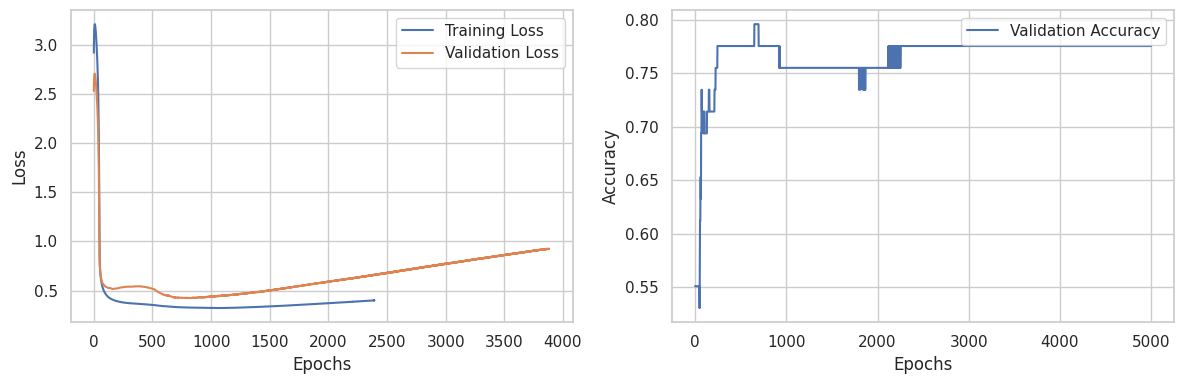

In [86]:
# After training, plot the losses and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Batch Gradient Decent

In [87]:
X_train = X_train_full.values.T
y_train = y_train_full.values.reshape(1, y_train_full.shape[0])
X_test = X_test.values.T
y_test = y_test.values.reshape(1, y_test.shape[0])

In [88]:
print ("Train X Shape: ", X_train.shape)
print ("Train Y Shape: ", y_train.shape)
print ("I have m = %d training examples!" % (X_train.shape[1]))

print ("\nTest X Shape: ", X_test.shape)

Train X Shape:  (13, 241)
Train Y Shape:  (1, 241)
I have m = 241 training examples!

Test X Shape:  (13, 61)


In [89]:
def define_structure(X, Y):
    input_unit = X.shape[0] # size of input layer
    hidden_unit = 32 #hidden layer of size 4
    output_unit = Y.shape[0] # size of output layer
    return (input_unit, hidden_unit, output_unit)
(input_unit, hidden_unit, output_unit) = define_structure(X_train, y_train)
print("The size of the input layer is:  = " + str(input_unit))
print("The size of the hidden layer is:  = " + str(hidden_unit))
print("The size of the output layer is:  = " + str(output_unit))

The size of the input layer is:  = 13
The size of the hidden layer is:  = 32
The size of the output layer is:  = 1


In [90]:
def parameters_initialization(input_unit, hidden_unit, output_unit):
    np.random.seed(2) 
    W1 = np.random.randn(hidden_unit, input_unit)*0.01
    b1 = np.zeros((hidden_unit, 1))
    W2 = np.random.randn(output_unit, hidden_unit)*0.01
    b2 = np.zeros((output_unit, 1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [91]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    
    return A2, cache

In [92]:
def cross_entropy_cost(A2, Y, parameters):
    # number of training example
    m = Y.shape[1] 
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
                                    
    return cost

In [93]:
def backward_propagation(parameters, cache, X, Y):
    #number of training example
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
   
    dZ2 = A2-Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), relu_derivative(A1))
    dW1 = (1/m) * np.dot(dZ1, X.T) 
    db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2}
    
    return grads

In [94]:
def gradient_descent(parameters, grads, learning_rate = 0.01):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
   
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1, "b1": b1,"W2": W2,"b2": b2}
    
    return parameters

In [95]:
# data used in batch gradient decent
split = int(0.8 * X_train.shape[1])
train_input = X_train[:,:split]
train_output = y_train[:,:split]
val_input = X_train[:,split:]
val_output = y_train[:,split:]

Cost after iteration 0: 0.693167
Validation Accuracy after iteration 0: 0.571429
Cost after iteration 1000: 0.689460
Validation Accuracy after iteration 1000: 0.571429
Cost after iteration 2000: 0.684791
Validation Accuracy after iteration 2000: 0.571429
Cost after iteration 3000: 0.611358
Validation Accuracy after iteration 3000: 0.755102
Cost after iteration 4000: 0.429790
Validation Accuracy after iteration 4000: 0.734694
Cost after iteration 5000: 0.377358
Validation Accuracy after iteration 5000: 0.775510
Cost after iteration 6000: 0.360103
Validation Accuracy after iteration 6000: 0.775510
Cost after iteration 7000: 0.351879
Validation Accuracy after iteration 7000: 0.755102
Cost after iteration 8000: 0.347311
Validation Accuracy after iteration 8000: 0.775510
Cost after iteration 9000: 0.344524
Validation Accuracy after iteration 9000: 0.775510
Cost after iteration 10000: 0.342695
Validation Accuracy after iteration 10000: 0.795918
Cost after iteration 11000: 0.341438
Validation

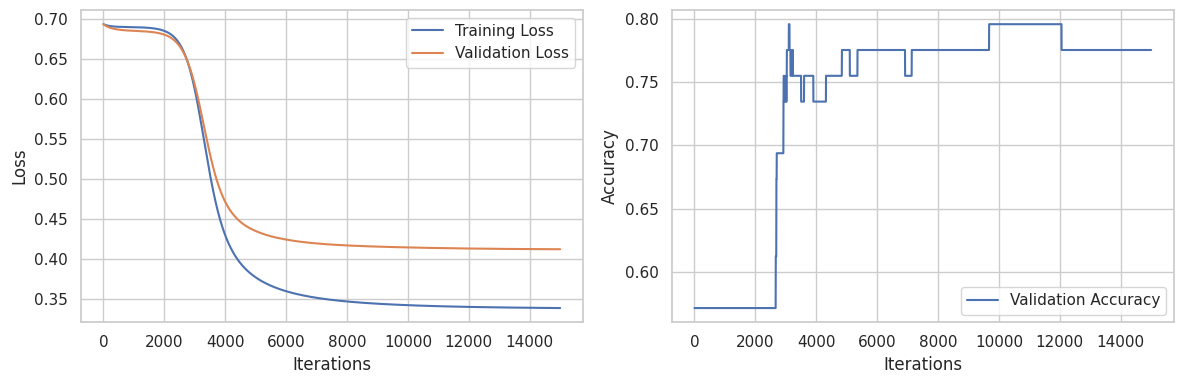

In [96]:
import matplotlib.pyplot as plt

def neural_network_model(X, Y, X_val, Y_val, hidden_unit, num_iterations = 1000):
    np.random.seed(3)
    input_unit = define_structure(X, Y)[0]
    output_unit = define_structure(X, Y)[2]
    
    parameters = parameters_initialization(input_unit, hidden_unit, output_unit)
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Initialize lists to store losses and accuracy
    train_losses = []
    val_losses = []
    val_accuracies = []

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = cross_entropy_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = gradient_descent(parameters, grads)
        
        train_loss = cost
        train_losses.append(train_loss)
        
        # Validation during training to calculate accuracy and cross-entropy loss
        A2_val, _ = forward_propagation(X_val, parameters)
        val_cost = cross_entropy_cost(A2_val, Y_val, parameters)
        val_loss = val_cost
        val_losses.append(val_loss)
        
        predictions = (A2_val > 0.5)
        val_accuracy = np.mean(predictions == Y_val)
        val_accuracies.append(val_accuracy)

        if i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            print(f"Validation Accuracy after iteration %i: %f" %(i, val_accuracy))

    # After training, plot the losses and accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return parameters

parameters = neural_network_model(train_input, train_output, val_input, val_output, 8, num_iterations=15000)

## Model

In [97]:
output = forward_propagation(X_test, parameters)

In [98]:
preds = output[0]

In [99]:
preds[preds > 0.5] = 1
preds[preds < 0.5] = 0

In [100]:
preds = preds.reshape(preds.shape[1],).tolist()

In [101]:
y_test = y_test.reshape(y_test.shape[1],).tolist()

In [102]:
cm = confusion_matrix(y_pred=preds, y_true = y_test )

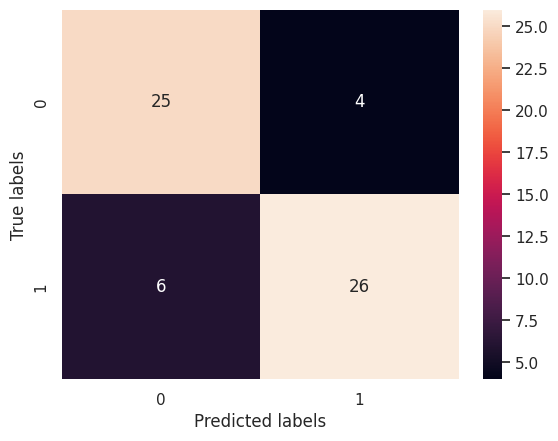

In [103]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

* 1. TP = 26
* 1. FP = 0
* 1. FN = 9
* 1. TN = 26

In [104]:
print("Classification Report:")
print(classification_report(y_test, preds)) # 0.80 accuracy

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83        29
         1.0       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

